# Farmland & Crops Image Crop

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.


In [6]:
import cv2
import numpy as np

def crop_around_center(image: object, width: int, height: int, crop_center: object = None):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point.

    Arguments:
    ----------
        image (3d-array): The original image vector.
        
        width (int): The desired width of the cropped image.
        
        height (int): The desired height of the cropped image.
        
        crop_center: ([x, y]): The coordinates of the center point to crop.
            
    Returns:
    --------
        image (3d-array): Cropped image.
            
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    image_size = (image.shape[1], image.shape[0])
    
    # 未提供中心座標的時候，預設為圖片正中心
    if(crop_center is None):
        image_center = [int(image_size[0] * 0.5), int(image_size[1] * 0.5)]
    else:
        image_center = [int(image_size[0] * 0.5 + crop_center[0]), int(image_size[1] * 0.5 + crop_center[1])]

    # 如果輸出寬度大於圖片寬度，則將輸出寬度設為圖片寬度
    if(width > image_size[0]):
        width = image_size[0]
        
    # 如果輸出高度大於圖片高度，則將輸出高度設為圖片高度
    if(height > image_size[1]):
        height = image_size[1]
        
    # 如果從 x 座標算起，輸出寬度會超出圖片邊界，則將 x 座標往左或往右推移
    x_boundary = (image_center[0] - int(width * 0.5), image_center[0] + int(width * 0.5))
    
    # 超出左邊界 beyond the left border
    if(x_boundary[0] < 0):
        image_center[0] = image_center[0] + abs(x_boundary[0])
        
    # 超出右邊界 beyond the right border
    if(x_boundary[1] > image_size[0]):
        image_center[0] = image_center[0] - abs(x_boundary[1] - image_size[0])
        
    # 如果從 y 座標算起，輸出高度會超出圖片邊界，則將 y 座標往上或往下推移
    y_boundary = (image_center[1] - int(height * 0.5), image_center[1] + int(height * 0.5))
    
    # 超出上邊界 beyond the upper bound
    if(y_boundary[0] < 0):
        image_center[1] = image_center[1] + abs(y_boundary[0])
        
    # 超出下邊界 beyond the lower boundary
    if(y_boundary[1] > image_size[1]):
        image_center[1] = image_center[1] - abs(y_boundary[1] - image_size[1])
        
    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)
    return image[y1:y2, x1:x2]

def load_image_and_resize(path: str, new_size: int = 224, crop_ratio: float = 0.5, crop_center: object = None):
    """
    Use CV2 to read image, and resize the image to make the aspect ratio. (crop first and then resize)
    
    Arguments:
    ----------
        path (str): The image path.  
        
        new_size (int): The desired image size.  
        
        crop_ratio (float): The ratio of the cropped area to the original image.  
        
        crop_center ([x, y]): The coordinates of the center point to crop.  

    Returns:
    --------
        image (3d-array): Image vector converted to rgb format.
    """
    
    image = cv2.imread(path)
    height, width, channel = image.shape
    crop_window = min(height, width) * crop_ratio
    image = crop_around_center(image, crop_window, crop_window, crop_center)
    image = cv2.resize(image, (new_size, new_size), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

## Playground
以官方提供的 `target_x` 與 `target_y` 為影像中心點進行裁切，使影像更聚焦在作物上面，可以觀察到官方的 x, y 設定似乎給反

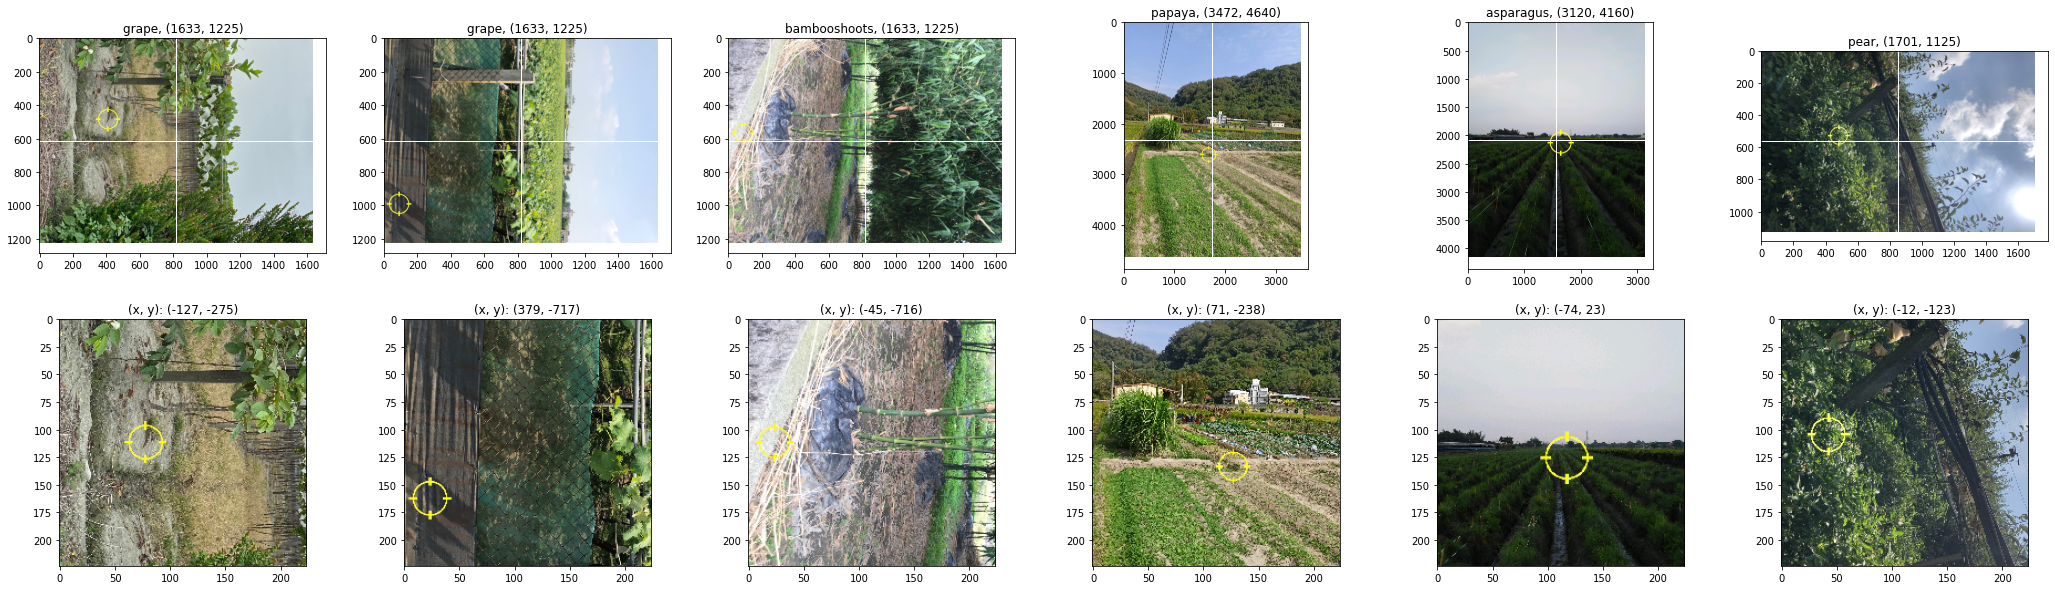

In [16]:
if __name__ == "__main__":
    
    import pandas as pd
    from matplotlib import pyplot as plt
    
    def row_based_idx(num_rows, num_cols, idx):
        return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]
    
    # Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
    path = ".."

    # Image size for model
    image_size = 224

    sample = pd.read_csv(F'{path}/sample/sample.csv')

    items = 6
    plt.figure(figsize=(items * 6, 10))
    for item in range(items):
        row = sample.iloc[item]
        # original image
        image = cv2.imread(F'{path}/sample/{row["file"]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, channel = image.shape
        ax = plt.subplot(2, items, row_based_idx(2, items, item * 2 + 1))
        plt.title("{}, {}".format(row["label"], row["shape"]))
        plt.imshow(image.astype("uint8"))
        plt.plot([0, width], [height * 0.5, height * 0.5], color="white", linewidth=1)
        plt.plot([width/2, width/2], [height, 0], color="white", linewidth=1)
        # cropped image
        cropped = load_image_and_resize(path=F'{path}/sample/{row["file"]}', crop_ratio=0.7, crop_center=(row["target_y"], row["target_x"]))
        ax = plt.subplot(2, items, row_based_idx(2, items, item * 2 + 2))
        plt.imshow(cropped.astype("uint8"))
        plt.title("(x, y): ({}, {})".format(row["target_x"], row["target_y"]))